In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
from scipy.optimize import least_squares
from tqdm import tqdm
import matplotlib as mpl
from scipy.stats import norm
from scipy.interpolate import interp1d
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
%matplotlib inline
mpl.rcParams.update({'font.size':10})

psth_bins = np.arange(-200,401)
plasma_map = plt.cm.plasma(np.linspace(0,1,15))
kcolors = {
    'movement': plasma_map[12,:],
    'early': plasma_map[10,:],
    'late': plasma_map[8,:],
    'biphasic': plasma_map[5,:],
    'negative': plasma_map[2,:],
    'unresponsive': 'dimgrey'
}
tcolors = {
    'gaze': 'firebrick',
    'comp': 'mediumblue',
    'rc': 'indigo'
}

# import fmEphys as fme
# import fmSaccades as fmsacc

KeyboardInterrupt: 

In [2]:
base_path = r'C:\Users\dmartins\Documents\Dropbox\Research\Niell_lab\Data\Gaze_shift_data\Marmoset\062022'
data = loadmat(os.path.join(base_path,
                'Pooled_V1Hart_Preload_Final.mat'))
totdata = loadmat(os.path.join(base_path,
                'Pooled_V1Hart_Preload_TotalInfo.mat'))['TotalInfo']

In [3]:
uNum = 0
unitlabels = ['tagname','pathname','pathplot','isolation','depth','duration',
              'waveform','channel','shank','ISI','Hart','SacGrating','SacImage']
unit_dict = dict(zip(unitlabels, list(totdata[uNum][0][0][0])))

sacimlabels = ['EventList','StimWin','TrialType','StimRast','OriInd','StimTT',
               'StimUU','StimSU','OriInd2','StimRast2','StimTT2','StimUU2',
               'StimSU2','BaseMu','BaseMu2']
sacim_dict = dict(zip(sacimlabels, list(unit_dict['SacImage'][0][0])))

In [4]:
sacc_psth = data['ISACMOD2']
grat_psth = data['GSACMOD']
sf_tuning = data['SFTUNE']
tf_tuning = data['TFTUNE']
ori_tuning = data['ORTUNE']
bsln_fr = data['BASEMU2']
peakT = data['PEAKIM2']
animal = data['ANIMID']

In [5]:
n_cells = np.size(peakT,0)

In [6]:
# spatial and temporal frequencies used
sf_vals = np.array([1,2,4,8,16])
tf_vals = (60/16) * np.arange(9)

tf_pref = np.zeros(n_cells); sf_pref = np.zeros(n_cells)
ori_index = np.zeros(n_cells)
tf_index = np.zeros(n_cells)
sf_index = np.zeros(n_cells)

for ind in range(n_cells):
    sf = sf_tuning[ind,:].copy()
    tf = tf_tuning[ind,:].copy()
    ori = ori_tuning[ind,:].copy()
    
    ofi = np.nanstd(ori) / np.nanmean(ori)
    sfi = np.nanstd(sf) / np.nanmean(sf)
    tfi = np.nanstd(tf) / np.nanmean(tf)
    
    svec = sf.copy()-1
    svec[svec<0] = 0
    svec = svec**2
    spref = np.nansum(svec * sf_vals) / np.nansum(svec)
    
    tvec = tf.copy()-1
    tvec[tvec<0] = 0
    tvec = tvec**2
    tpref = np.nansum(tvec * tf_vals) / np.nansum(tvec)
    
    sf_pref[ind] = spref
    tf_pref[ind] = tpref
    ori_index[ind] = ofi
    sf_index[ind] = sfi
    tf_index[ind] = tfi

In [7]:
clusters = np.load(os.path.join(base_path,
                                'marmoset_clusters.npy'))

In [8]:
kord = [2,0,3,1]
k_list = ['early','late','biphasic','negative']
k_dict = dict(zip(k_list, kord))

In [9]:
grat_resp = np.zeros(n_cells)
for ind in range(n_cells):
    ffi = np.sqrt(ori_index[ind]**2 + sf_index[ind]**2)
    if ffi >= 0.2:
        grat_resp[ind] = True
grat_resp = grat_resp.astype(bool)

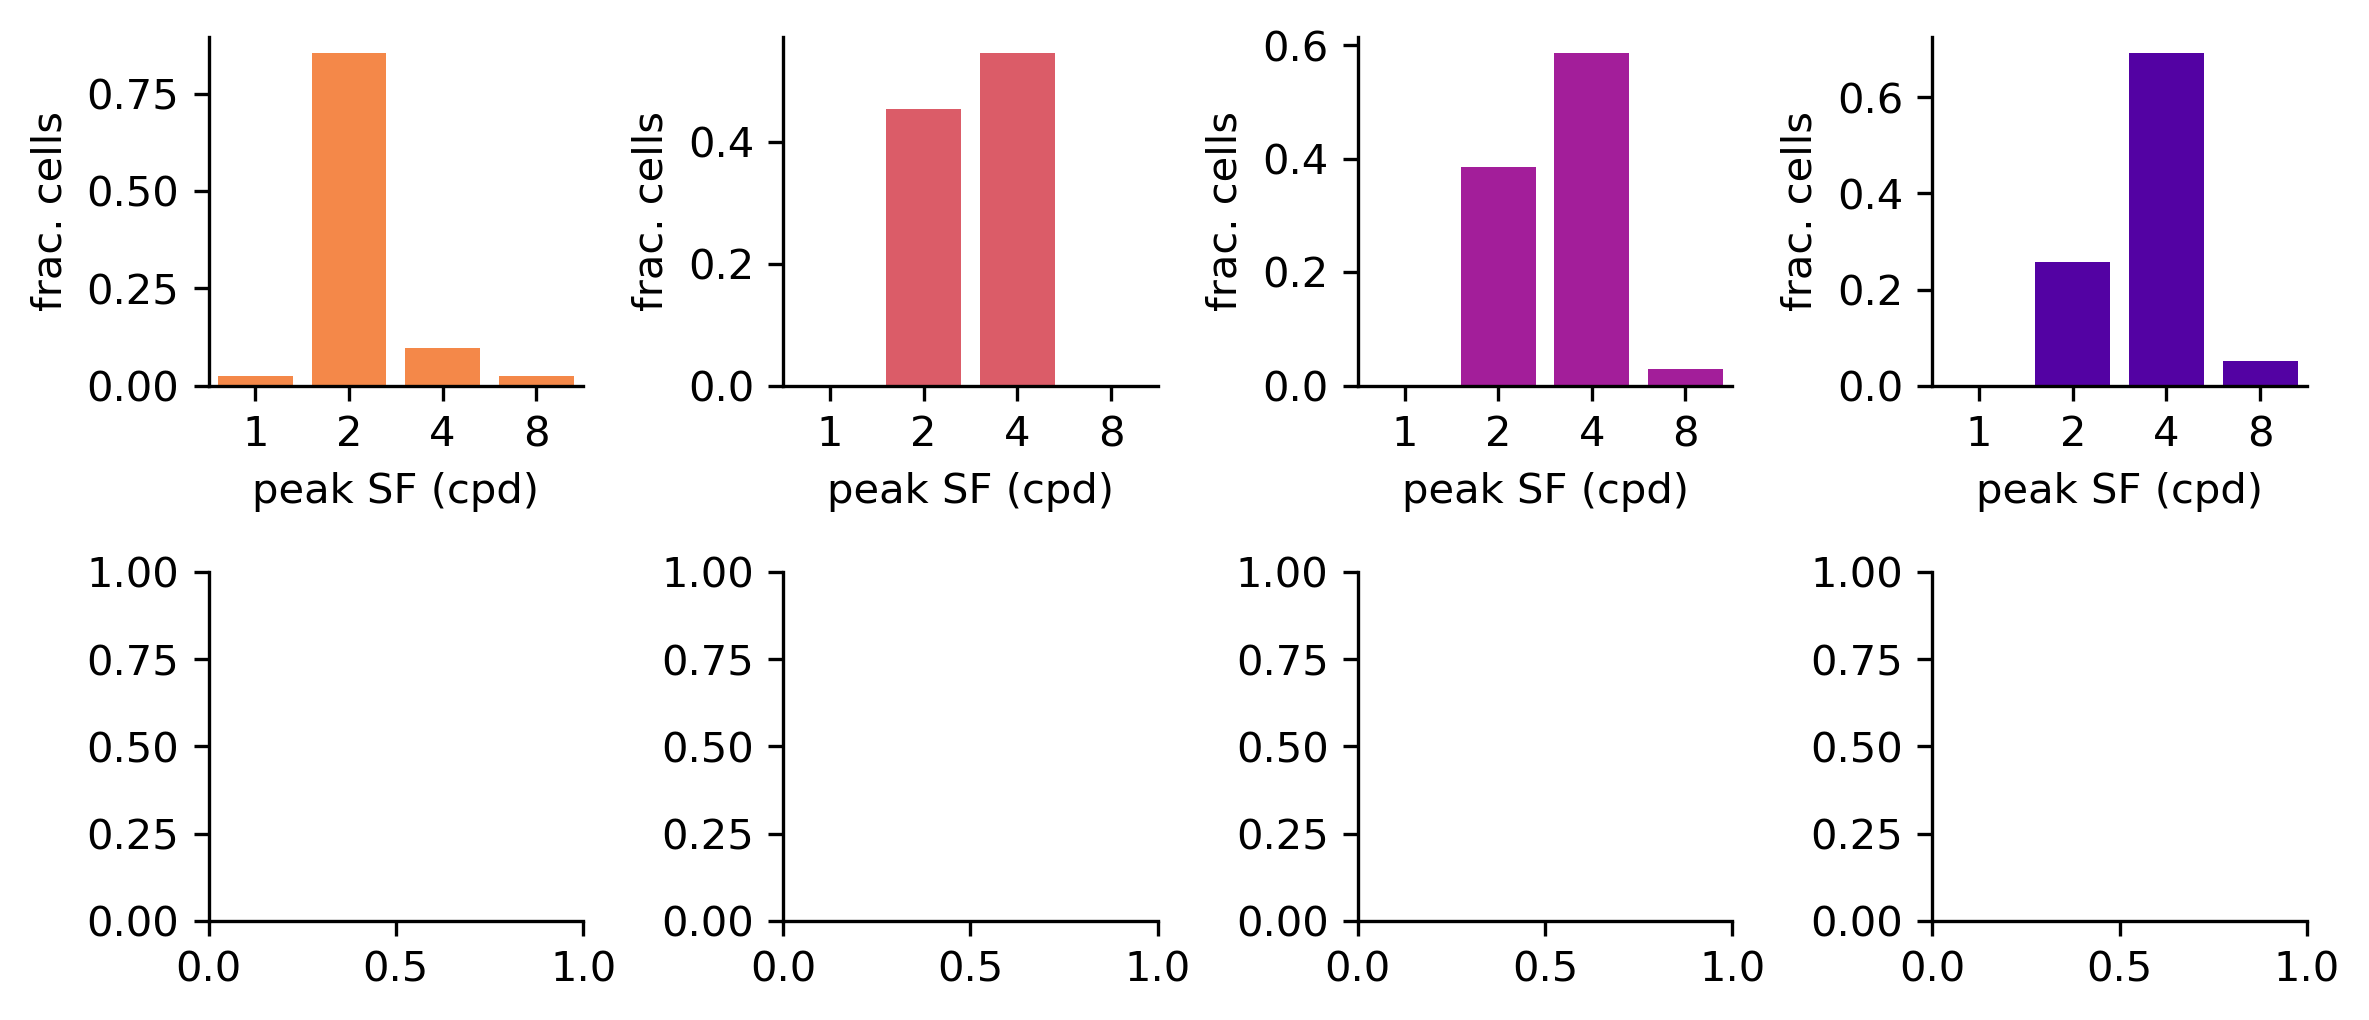

In [23]:
fig, axs = plt.subplots(2,4, figsize=(8,3.5), dpi=300)

# axs = axs.flatten()

for p in range(4):

    ax = axs[0,p]

    kname = k_list[p]

    use = (grat_resp) * (clusters==k_dict[kname])

    peak_vals = []
    for i, ind in enumerate(np.where(use)[0]):
        pv = np.nanargmax(sf_tuning[ind,:])
        peak_vals.append(pv)

    # print(peak_vals)
    _vals, _counts = np.unique(peak_vals, return_counts=True)
    # print(kname, _vals, _counts, np.sum(_counts))
    _valcounts = dict(zip(_vals, _counts/np.sum(use)))

    for k,v in _valcounts.items():
        ax.bar(k,v, color=kcolors[kname])
    ax.set_xlim([-.5,3.5])
    ax.set_xticks([0,1,2,3], labels=[1,2,4,8])
    # ax.set_title(kname + ' (n=' + str(np.sum(use)) + ')')
    # ax.set_xticks(range(5), labels=sf_vals)
    ax.set_ylabel('frac. cells')
    if k>1:
        ax.set_xlabel('peak SF (cpd)')

    # ax1 = axs[1,p]

    # _show_means = gaus_fits[kname][:,1].copy()
    # _show_means[_show_means<0] = 0
    # _show_means[_show_means>3] = 3
    
    # ax1.hist(_show_means, bins=np.linspace(0,3,8), color=kcolors[kname])
    # # ax1.set_title(kname)

    # ax1.set_xlim([0,3])
    # ax1.set_xticks([0,1,2,3,4], labels=[1,2,4,8,16])
    # ax1.set_ylabel('cells')
    # ax1.set_xlabel('gaussian mean (cpd)')
    
    # ax.set_title(kname)

    # ax.plot()

fig.tight_layout()
fig.savefig('marmo_sf_peaks.pdf')

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4.5,2.5), dpi=300)

for p, in range(4):

    kname = k_list[p]

    use = (grat_resp) * (clusters==k_dict[kname])

    peak_vals = []
    for i, ind in enumerate(np.where(use)[0]):
        pv = np.nanargmax(sf_tuning[ind,:])
        peak_vals.append(pv)

    # print(peak_vals)
    _vals, _counts = np.unique(peak_vals, return_counts=True)
    # print(kname, _vals, _counts, np.sum(_counts))
    _valcounts = dict(zip(_vals, _counts/len(peak_vals)))

    for k,v in _valcounts.items():
        ax.bar(k,v, color=kcolors[kname])
    ax.set_xlim([-.5,4.5])
    ax.set_title(kname + ' (n=' + str(np.sum(use)) + ')')
    # ax.set_xticks(range(5), labels=sf_vals)
    ax.set_ylabel('# cells')
    ax.set_xlabel('best sf (cpd)')

In [12]:
from scipy.optimize import curve_fit
from scipy.optimize import minimize

In [13]:
def gaus(x,a,mu,sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

In [13]:
gaus_fits = {}
for kname in k_list:

    use = (grat_resp & (clusters==k_dict[kname]))
    inds = np.where(use)[0]

    gaus_fits[kname] = np.zeros([len(inds), 3])

    for i, ind in enumerate(inds):

        used_sf_bins = ~np.isnan(sf_tuning[ind,:])
        stune = sf_tuning[ind, used_sf_bins].copy()
        _stune = stune - np.nanmin(stune)
        _stune = _stune / np.nanmax(_stune)

        popt, pcov = curve_fit(gaus, np.arange(0,4,1), _stune,
                            p0=[1., 1.5, 3.],
                            method='trf',
                            xtol=1e-15,
                            ftol=1e-15,
                            gtol=1e-15,
                            tr_solver='exact',
                            max_nfev=100000)
        
        gaus_fits[kname][i,:] = popt

c:\Users\dmartins\Anaconda3\envs\ephys1\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: divide by zero encountered in divide
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm


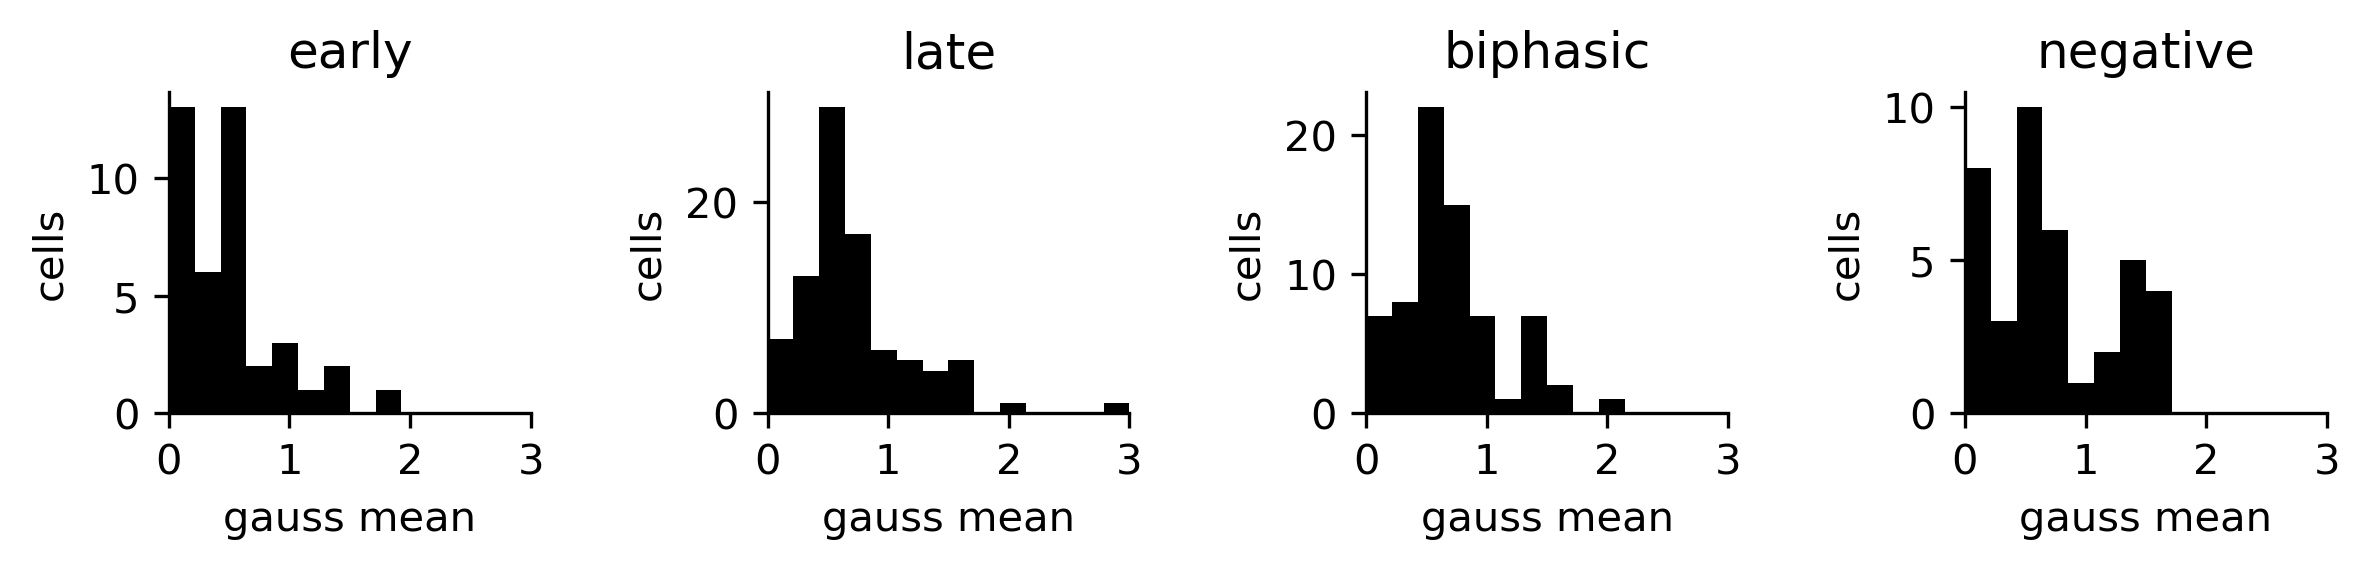

In [227]:
fig, axs = plt.subplots(1,4, figsize=(8,2), dpi=300)

for k, kname in enumerate(k_list):

    ax = axs[k]

    _show_means = gaus_fits[kname][:,1].copy()
    _show_means[_show_means<0] = 0
    _show_means[_show_means>3] = 3
    
    ax.hist(_show_means, bins=np.linspace(0,3,15), color='k')
    ax.set_title(kname)

    ax.set_xlim([0,3])
    ax.set_xticks([0,1,2,3])
    ax.set_ylabel('cells')
    ax.set_xlabel('gauss mean')

fig.tight_layout()
fig.savefig('marmo_gauss_means.pdf')


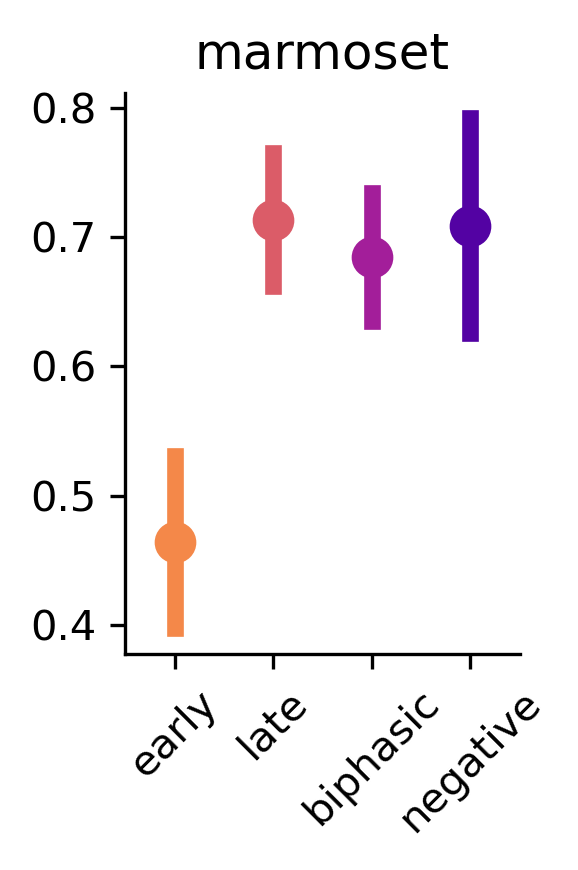

In [244]:
fig, ax = plt.subplots(1,1, figsize=(2,3), dpi=300)

for k, kname in enumerate(k_list):
    _show_means = gaus_fits[kname][:,1].copy()
    _show_means[_show_means<0] = 0
    _show_means[_show_means>3] = 3
    
    _mean = np.nanmean(_show_means)
    _stderr = np.nanstd(_show_means) / np.sqrt(np.sum(~np.isnan(_show_means)))

    ax.plot(k, _mean, 'o', color=kcolors[kname], ms=9)
    ax.plot([k,k], [_mean-_stderr, _mean+_stderr], '-', color=kcolors[kname], lw=4)
ax.set_xlim([-.5,3.5])
ax.set_xticks(range(4), labels=k_list, rotation=45)
ax.set_title('marmoset')
ax.set_ylim([])

fig.tight_layout()
fig.savefig('marmo_gauss_means_summary.pdf')



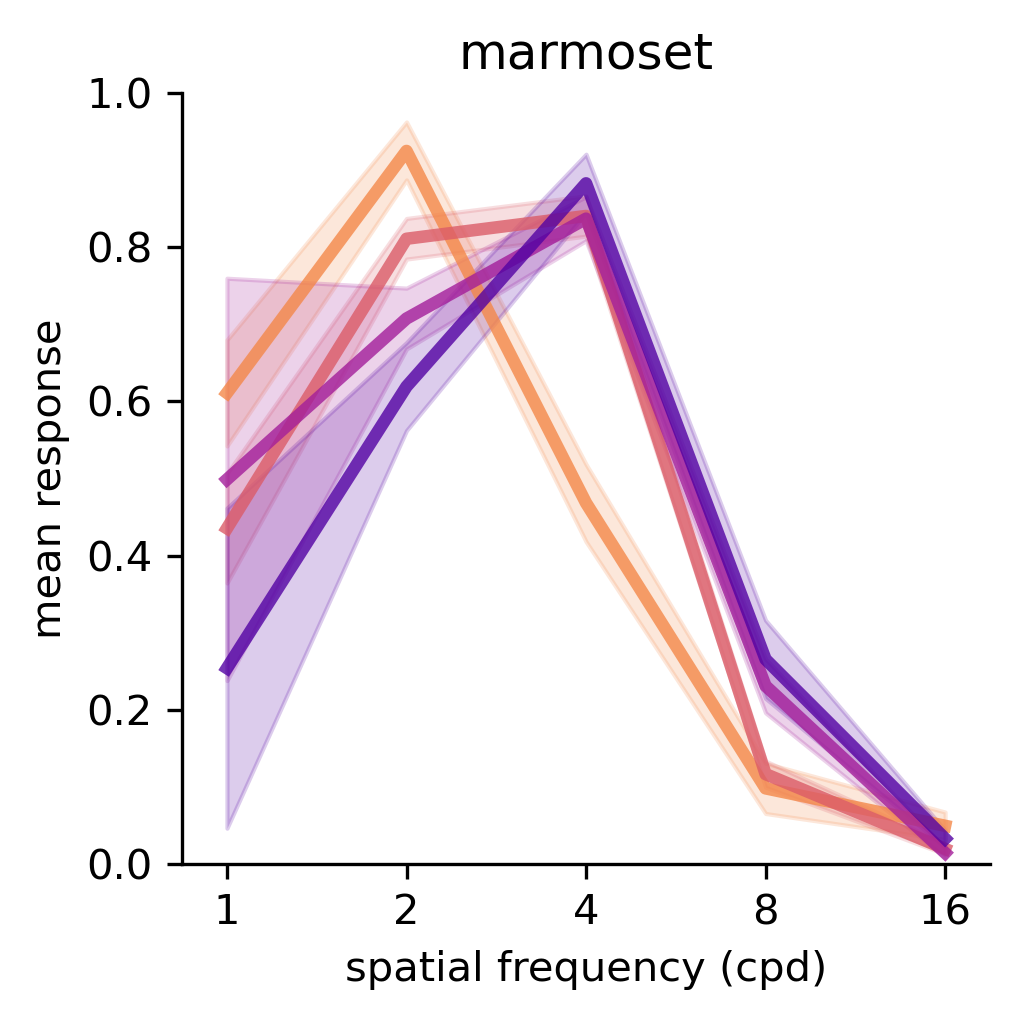

In [33]:
fig, ax = plt.subplots(1,1, figsize=(3.5,3.5), dpi=300)

_all_other_stune = np.zeros([0,5])

for k, kname in enumerate(k_list):

    use = (grat_resp & (clusters==k_dict[kname]))
    inds = np.where(use)[0]

    gaus_fits[kname] = np.zeros([len(inds), 3])

    _all_stune = np.zeros([len(inds), 5])*np.nan

    for i, ind in enumerate(inds):

        used_sf_bins = ~np.isnan(sf_tuning[ind,:])
        stune = sf_tuning[ind, used_sf_bins].copy()
        _stune = stune - np.nanmin(stune)
        _stune = _stune / np.nanmax(_stune)

        _all_stune[i, np.where(used_sf_bins)[0]] = _stune

    _show_mean = np.nanmean(_all_stune, axis=0)
    _show_stderr = np.nanstd(_all_stune, axis=0) / np.sqrt(np.sum(~np.isnan(_all_stune), axis=0))

    ax.plot(range(5), _show_mean,
                    color=kcolors[kname], label=kname, lw=3, alpha=0.8)
    ax.fill_between(range(5), _show_mean+_show_stderr, _show_mean-_show_stderr,
                    color=kcolors[kname], alpha=0.2)

    # if k>0:
    _all_other_stune = np.concatenate([_all_other_stune, _all_stune], axis=0)
    
# ax.plot(range(5), np.nanmean(_all_other_stune, axis=0),
#                 color='grey', label='not early', lw=3, alpha=0.5)
# ax.legend()
ax.set_xlim([-.25,4.25])
ax.set_ylim([0,1])
ax.set_xticks(range(5), labels=[1,2,4,8,16])
ax.set_xlabel('spatial frequency (cpd)')
ax.set_ylabel('mean response')
ax.set_title('marmoset')

fig.tight_layout()
fig.savefig('marmo_mean_tuning.pdf')

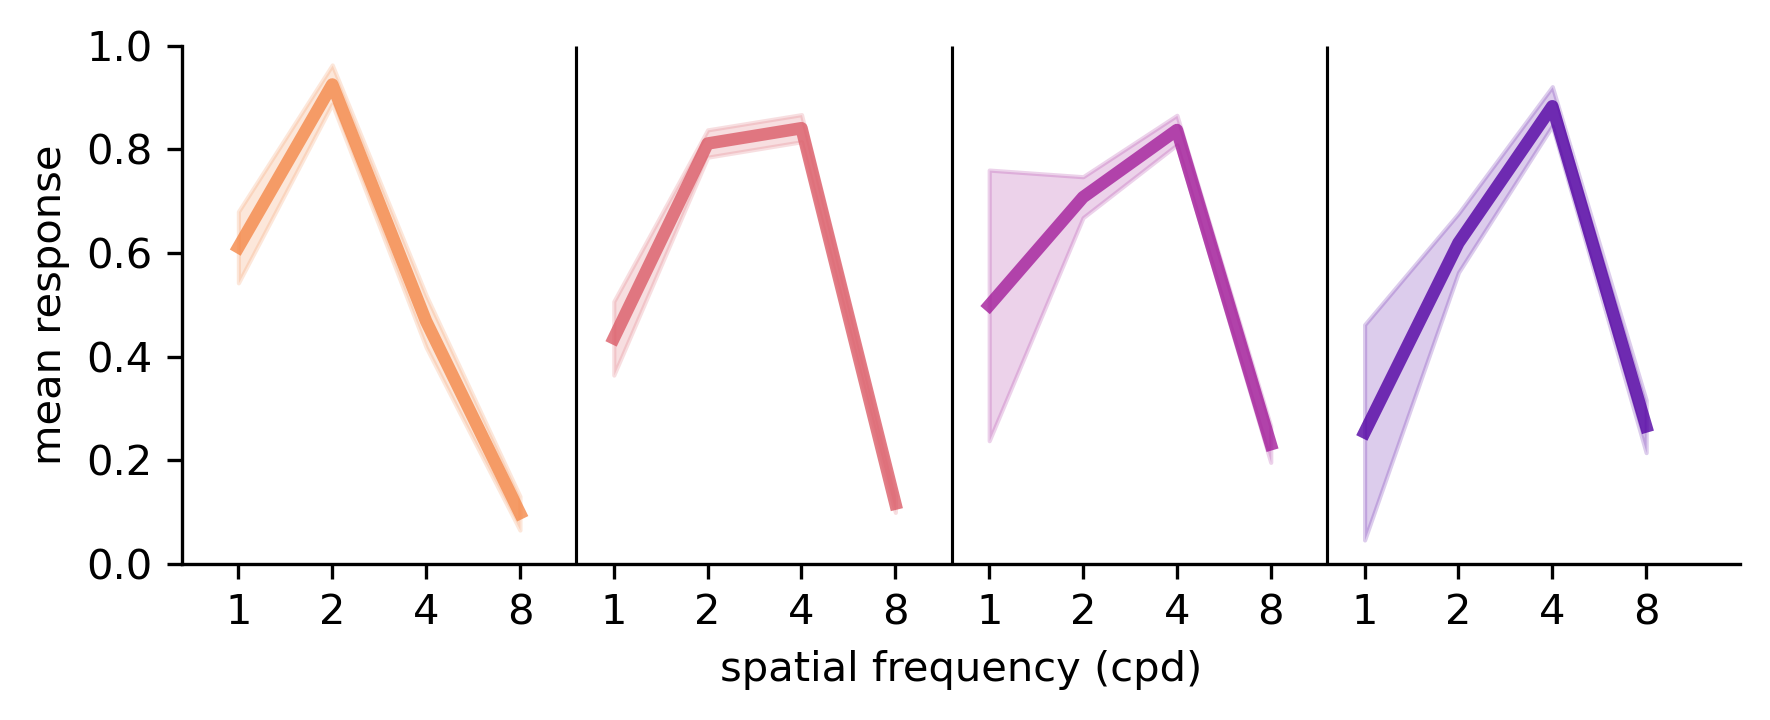

In [16]:
fig, ax = plt.subplots(1,1, figsize=(6,2.5), dpi=300)

all_x_positions = []
all_x_labels = []

for k, kname in enumerate(k_list):

    use = (grat_resp & (clusters==k_dict[kname]))
    inds = np.where(use)[0]

    _all_stune = np.zeros([len(inds), 5])*np.nan

    for i, ind in enumerate(inds):

        used_sf_bins = ~np.isnan(sf_tuning[ind,:])
        stune = sf_tuning[ind, used_sf_bins].copy()
        _stune = stune - np.nanmin(stune)
        _stune = _stune / np.nanmax(_stune)

        _all_stune[i, np.where(used_sf_bins)[0]] = _stune

    _show_mean = np.nanmean(_all_stune, axis=0)
    _show_stderr = np.nanstd(_all_stune, axis=0) / np.sqrt(np.sum(~np.isnan(_all_stune), axis=0))

    x_positions = [k, k+0.25, k+.5, k+.75]#, k+.8]
    all_x_positions += x_positions

    if k != 0:
        ax.vlines(k-.10, 0, 1, color='k', lw=.75)

    ax.plot(x_positions, _show_mean[:-1],
                    color=kcolors[kname], label=kname, lw=3, alpha=0.8)
    ax.fill_between(x_positions, _show_mean[:-1]+_show_stderr[:-1], _show_mean[:-1]-_show_stderr[:-1],
                    color=kcolors[kname], alpha=0.2)

    all_x_labels += [1,2,4,8]

# ax.legend()
ax.set_xlim([-.15,4.])
ax.set_ylim([0,1])
ax.set_xticks(all_x_positions, labels=all_x_labels)
ax.set_xlabel('spatial frequency (cpd)')
ax.set_ylabel('mean response')
# ax.set_title('marmoset')

fig.tight_layout()
fig.savefig('marmo_mean_tuning.pdf')

In [23]:
np.isnan(_all_other_stune[:,0]).sum(axis=0)

202

In [24]:
np.sum(~np.isnan(_all_other_stune[:,0]), axis=0)

36

In [26]:
_all_other_stune.shape

(238, 5)

In [18]:
_all_stune

array([[       nan, 0.70308891, 1.        , 0.12775837, 0.        ],
       [       nan, 1.        , 0.75429195, 0.        , 0.0241367 ],
       [       nan, 0.69890639, 1.        , 0.        , 0.05559146],
       [       nan, 0.41572166, 1.        , 0.07002717, 0.        ],
       [       nan, 0.2845773 , 1.        , 0.11030209, 0.        ],
       [       nan, 0.82628574, 1.        , 0.07550009, 0.        ],
       [       nan, 0.37595668, 1.        , 0.1485642 , 0.        ],
       [       nan, 1.        , 0.72541464, 0.24304356, 0.        ],
       [       nan, 0.61269686, 1.        , 0.28489162, 0.        ],
       [       nan, 0.50598082, 1.        , 0.10004552, 0.        ],
       [       nan, 0.83464795, 1.        , 0.05205492, 0.        ],
       [       nan, 0.93224122, 1.        , 0.01440695, 0.        ],
       [       nan, 0.05931515, 0.89061554, 1.        , 0.        ],
       [       nan, 0.        , 1.        , 0.31603585, 0.08087525],
       [       nan, 0.35106715, 1.

array([ 0.99050666, -0.02019793,  1.40254973])

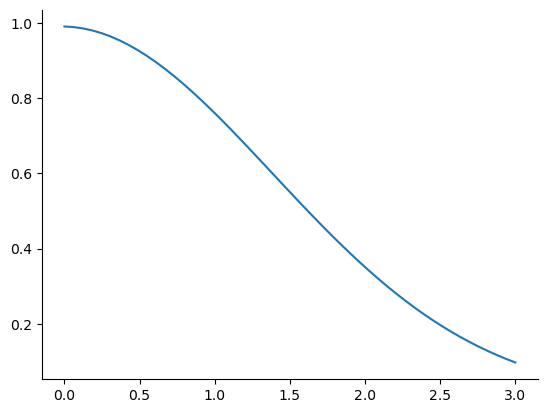

In [192]:
i = 15
plt.plot(np.linspace(0,3),
        gaus(np.linspace(0,3),
            gaus_fits[kname][i,0],
            gaus_fits[kname][i,1],
            gaus_fits[kname][i,2]))
gaus_fits[kname][i,:]

0.5576316436240456

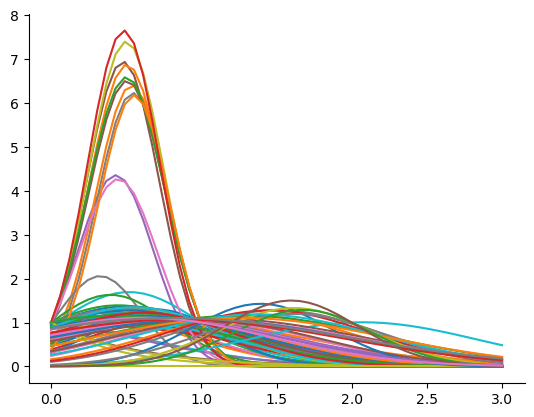

In [180]:
kname = 'late'
for i in range(gaus_fits[kname].shape[0]):
    plt.plot(np.linspace(0,3),
             gaus(np.linspace(0,3),
                  gaus_fits[kname][i,0],
                  gaus_fits[kname][i,1],
                  gaus_fits[kname][i,2]))

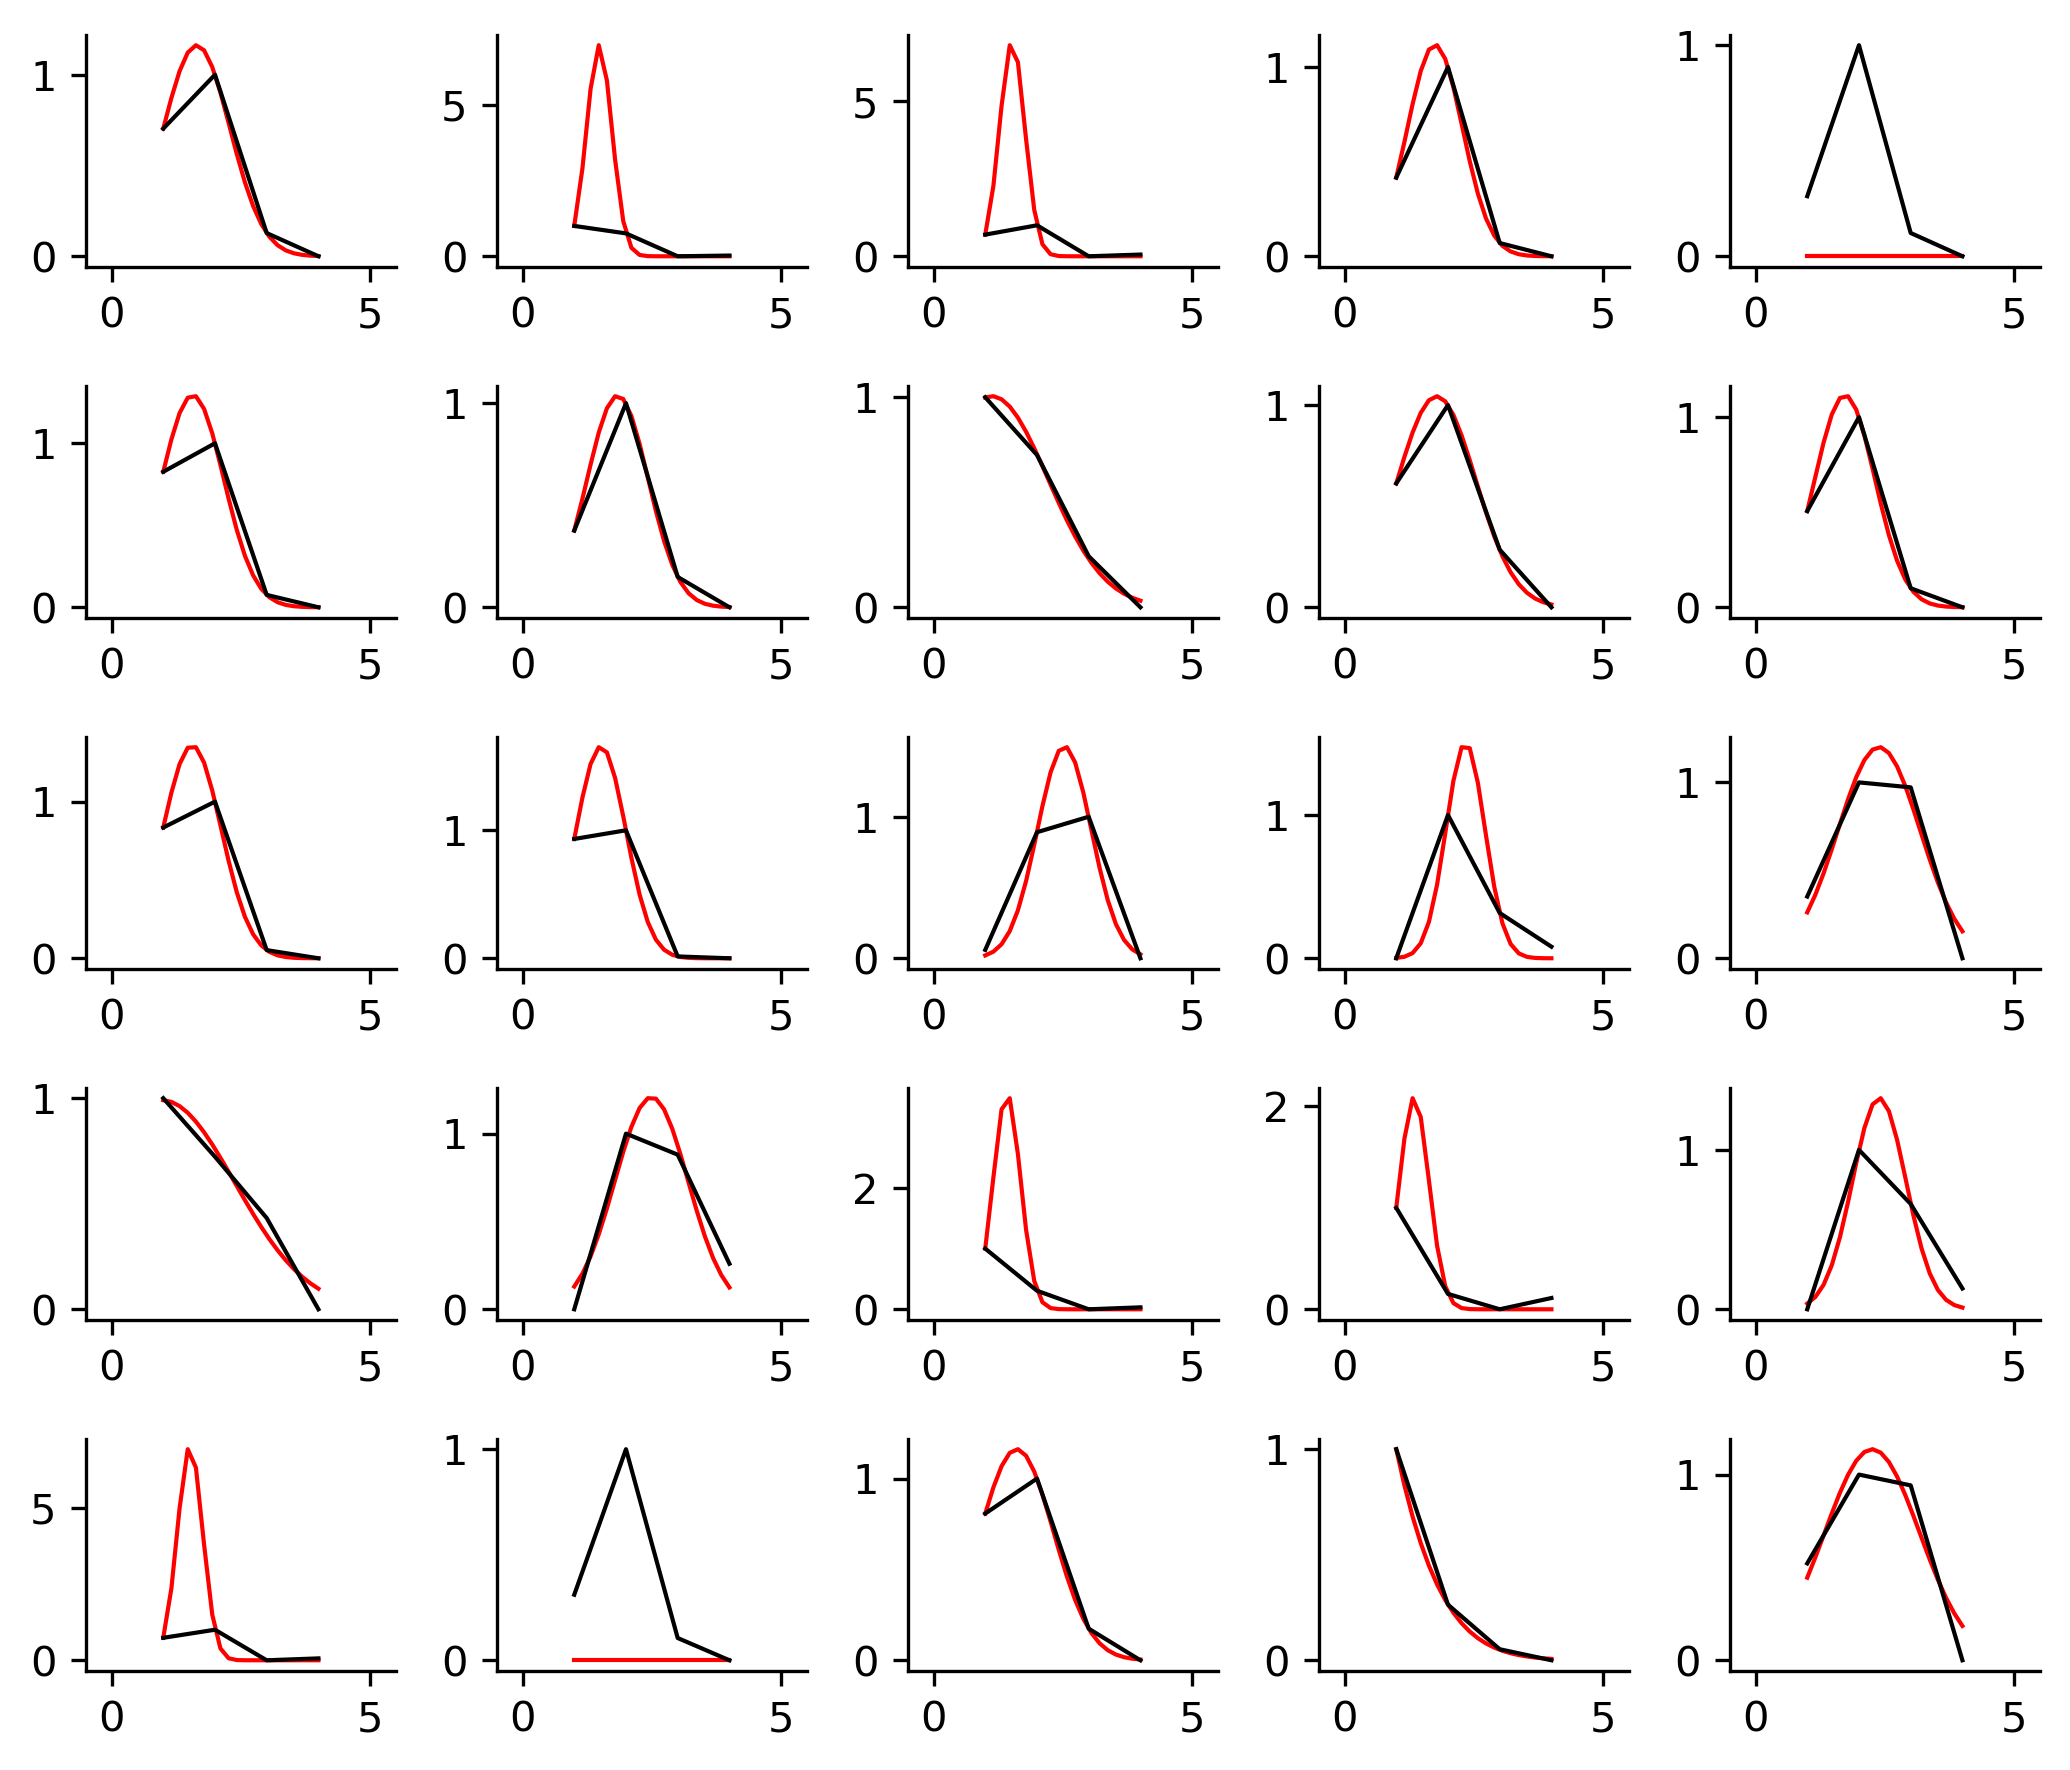

In [220]:
def gaussian(x, std, mean):
    # x = np.arange(0,4,1)
    return 1./(np.sqrt(std**np.pi))*np.exp(-std*np.power((x - mean), 2.))

kname = 'negative'

fig, axs = plt.subplots(5,5, figsize=(7,6), dpi=300)
axs = axs.flatten()

for p, ax in enumerate(axs):

    use = (grat_resp & (clusters==k_dict[kname]))
    ind = np.where(use)[0][p]

    used_sf_bins = ~np.isnan(sf_tuning[ind,:])
    stune = sf_tuning[ind, used_sf_bins].copy()
    _stune = stune - np.nanmin(stune)
    _stune = _stune / np.nanmax(_stune)

    popt, pcov = curve_fit(gaus, np.arange(0,4,1), _stune,
                           p0=[1., 1.5, 3.],
                           method='trf',
                           xtol=1e-15,
                           ftol=1e-15,
                           gtol=1e-15,
                           tr_solver='exact',
                           max_nfev=50000)
    # print(popt)
    # popt, pcov = curve_fit(f=gaussian,
    #                        xdata=np.arange(0,4,1),
    #                        method='trf',
    #                     #    tol=1e-15,
    #                     #    options={'maxiter':10000},
    #                        ftol=1e-15,
    #                        gtol=1e-15,
    #                        ydata=_stune,
    #                        p0=[1., 1.5],
    #                        xtol=1e-15,
    #                        tr_solver='exact',
    #                        max_nfev=10000
    #                        )
    # std, mean = popt

    xx = np.linspace(0,3,20)
    xx_ = xx.copy()
    xx_ar = np.arange(0,4,1)
    # _plotw1 = np.arange(0,4)
    if used_sf_bins[0]==False:
        xx_ += 1
        xx_ar += 1
        # _plotw1 += 1

    ax.set_xlim([-.5,5.5])

    ax.plot(xx_, gaus(xx, *popt), color='r', lw=1)

    ax.plot(xx_ar, _stune, '-', color='k', lw=1)
    # peak_val = np.nanargmax(sf_tuning[i,:])
    # ax.plot(sf_vals[peak_val], sf_tuning[i,peak_val], '*', color='r', ms=4)
    # ax.set_title('{}'.format(popt))
    # ax.set_title('{}'.format(np.round(popt[2],2)))

fig.tight_layout()
fig.savefig('marmo_'+kname+'_gaus_fits.pdf')


In [160]:
popt

array([7.17239823, 0.49644856, 0.25009193])

In [114]:
np.arange(0,4,1)

array([0, 1, 2, 3])

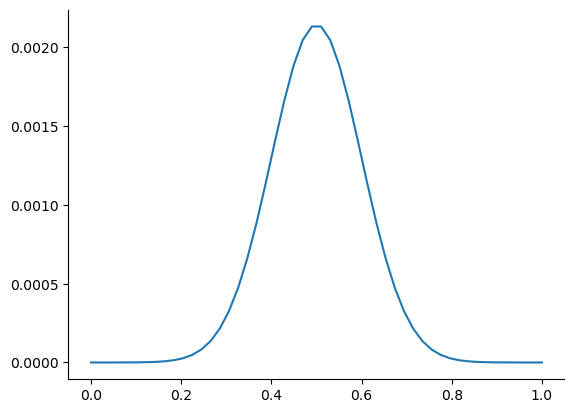

In [37]:
plt.plot(np.linspace(0,1), gaussian(np.linspace(0,1), 50, .5))

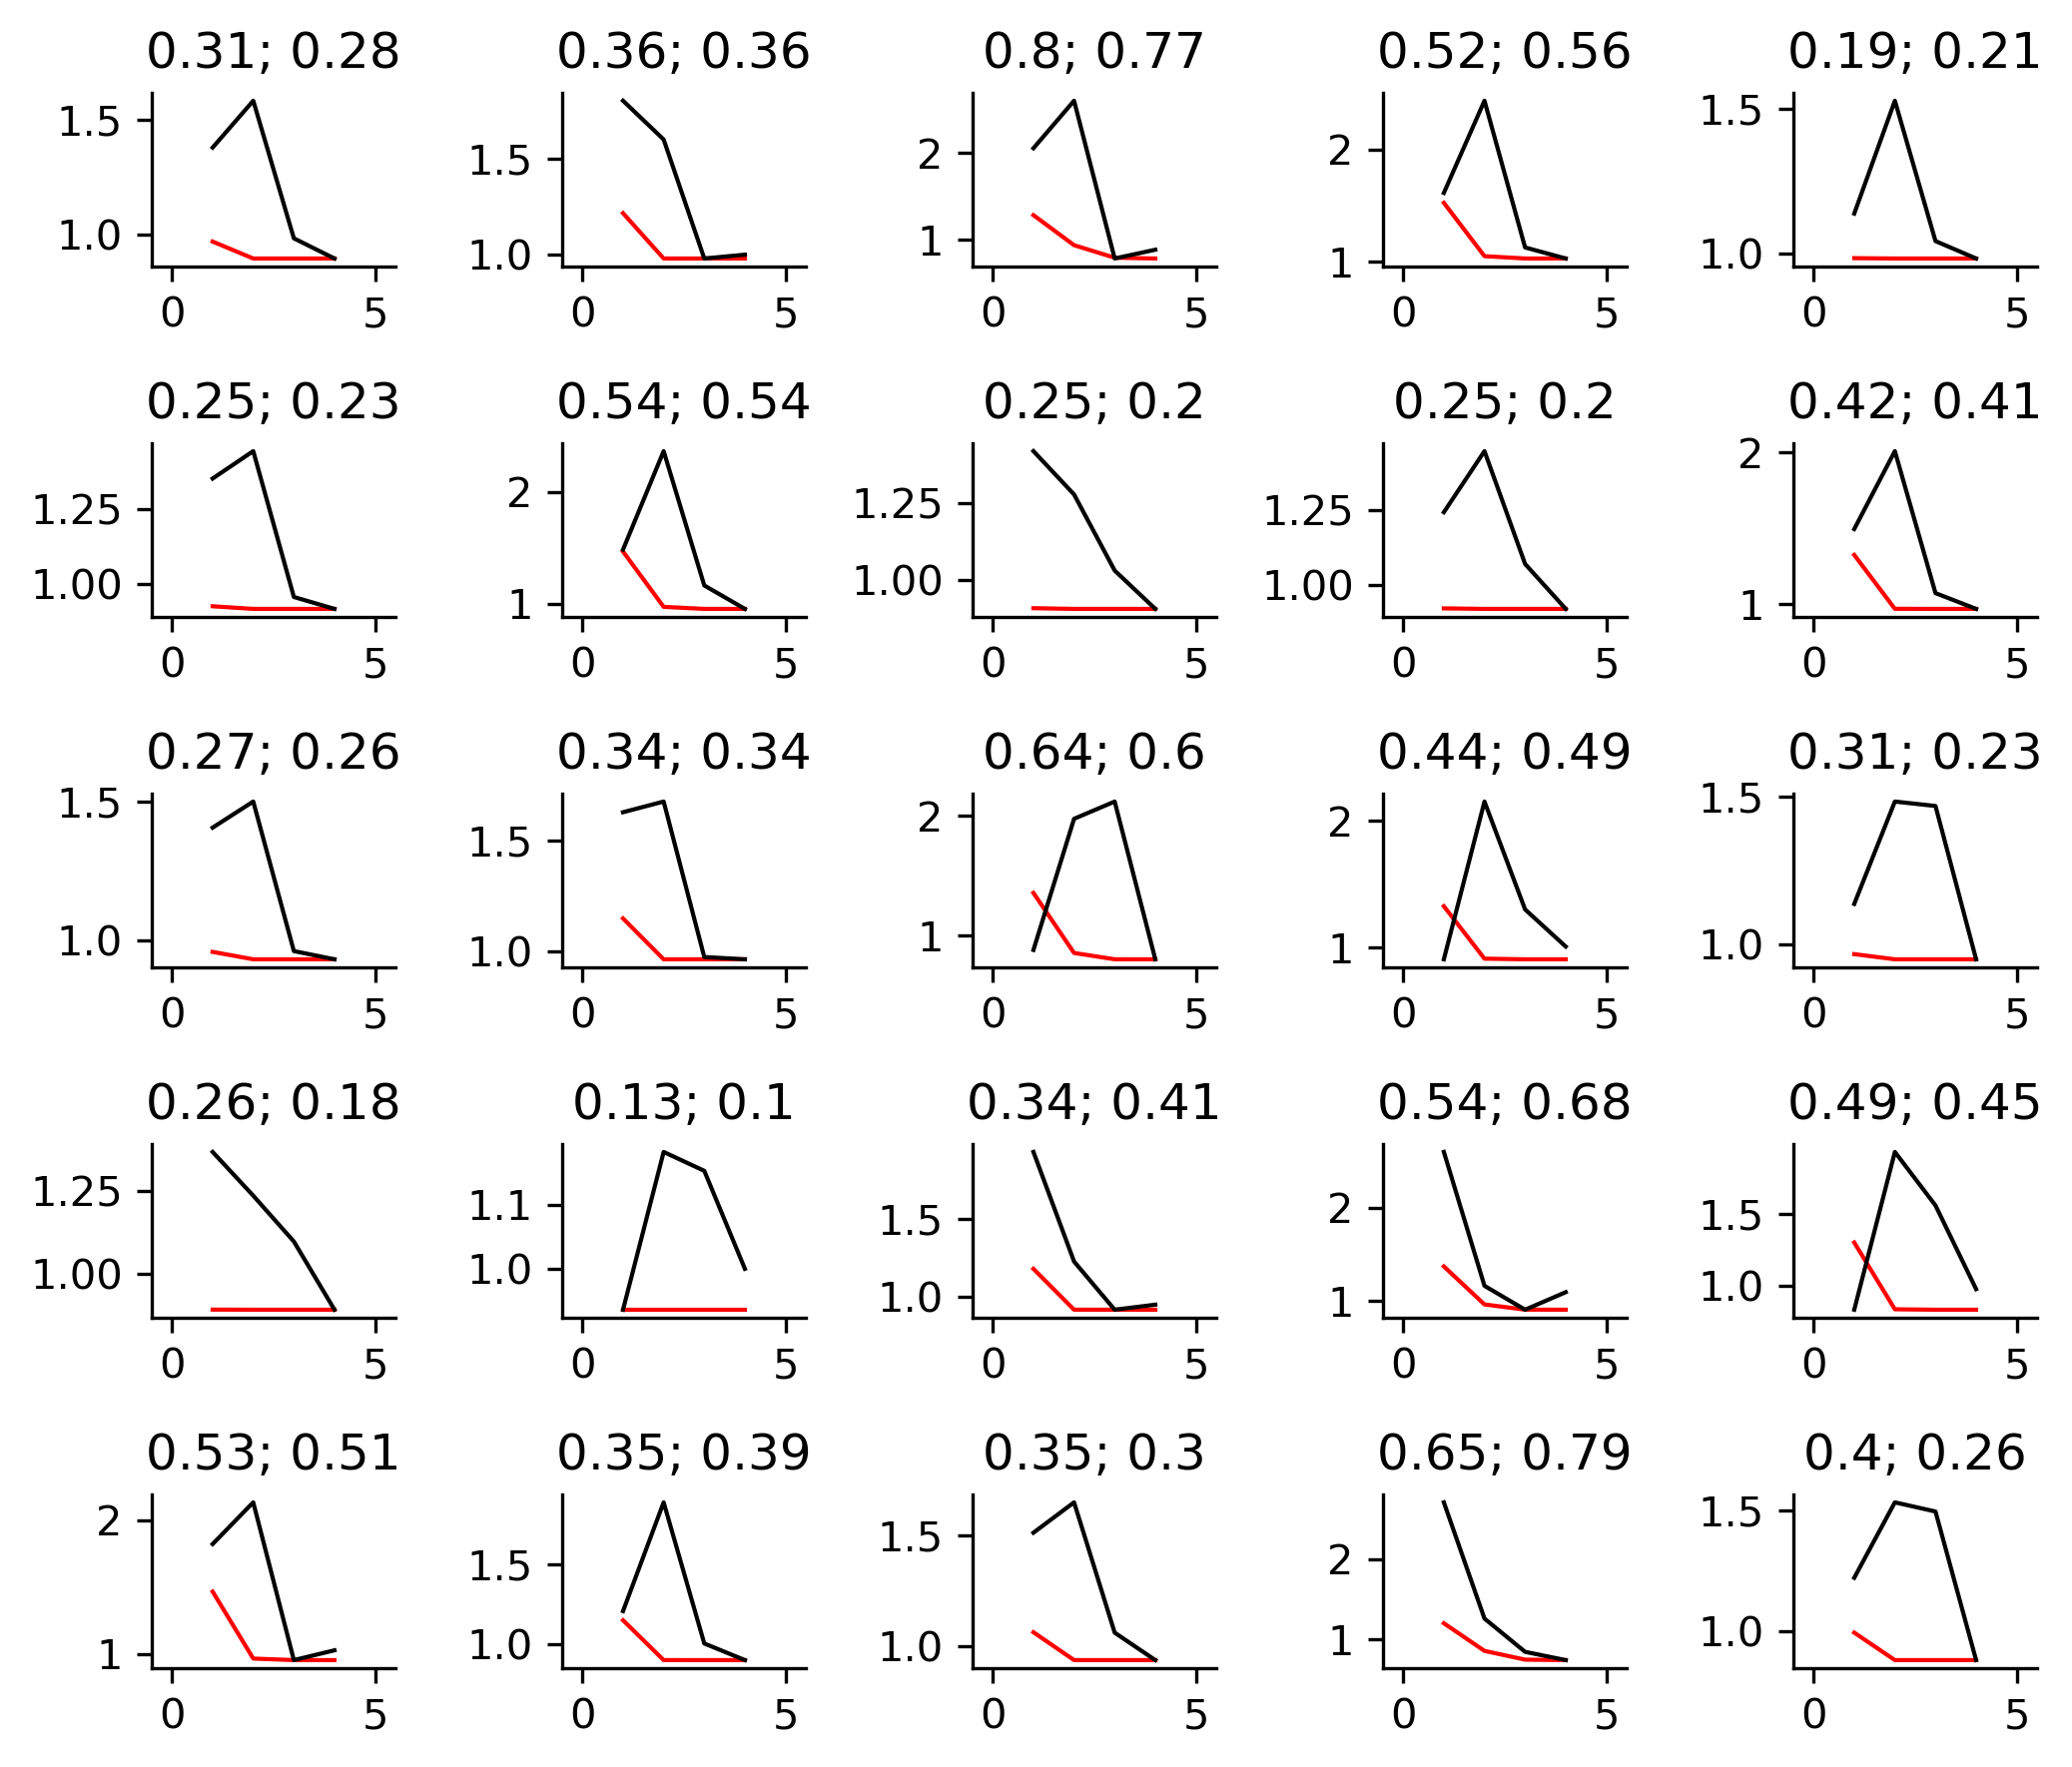

In [116]:
kname = 'negative'

fig, axs = plt.subplots(5,5, figsize=(7,6), dpi=300)
axs = axs.flatten()

for p, ax in enumerate(axs):

    use = (grat_resp & (clusters==k_dict[kname]))
    ind = np.where(use)[0][p]

    used_sf_bins = ~np.isnan(sf_tuning[ind,:])
    stune = sf_tuning[ind, used_sf_bins].copy()
    _stune = stune - np.nanmin(stune)

    mean, std = norm.fit(_stune)

    _plotw = np.arange(0,4,1)
    if used_sf_bins[0]==False:
        _plotw += 1

    ax.set_xlim([-.5,5.5])

    ax.plot(_plotw, norm.pdf(_plotw, mean, std)+np.nanmin(stune), color='r', lw=1)

    ax.plot(_plotw,
            stune,
            '-', color='k', lw=1)

    ax.set_title('{:.2}; {:.2}'.format(mean, std))

fig.tight_layout()
# fig.savefig('marmo_'+kname+'_peaks.png')


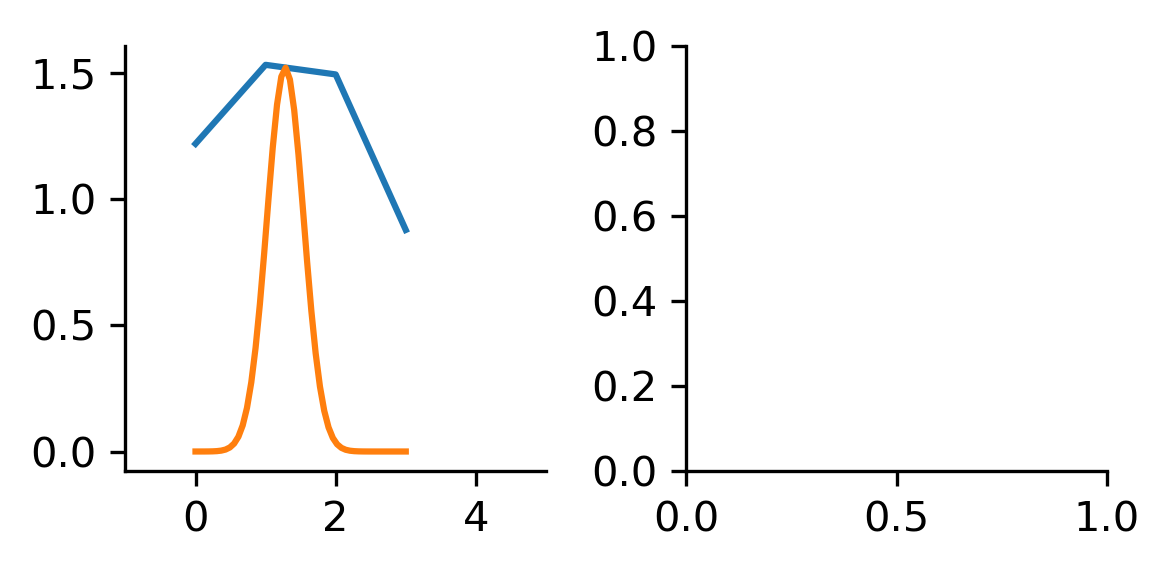

In [309]:
_sftuning = sf_tuning[186,:].copy() # 186
use = ~np.isnan(_sftuning)
_sftuning = _sftuning[use]
# plt.plot(sf_vals[use], _sftuning)
# new_sfvals = np.linspace(2,16,35)
# _sftuning = interp1d(sf_vals[use], _sftuning)(new_sfvals)
# plt.plot(new_sfvals, _sftuning)
mean, std = norm.fit(_sftuning)
fig, [ax1,ax2] = plt.subplots(1,2, figsize=(4,2), dpi=300)
ax1.plot(_sftuning)
ax1.plot(np.linspace(0,3), norm.pdf(np.linspace(0,3), mean, std))
ax1.set_xlim([-1,5])
# ax2.set_xlim([-1,5])

fig.tight_layout()

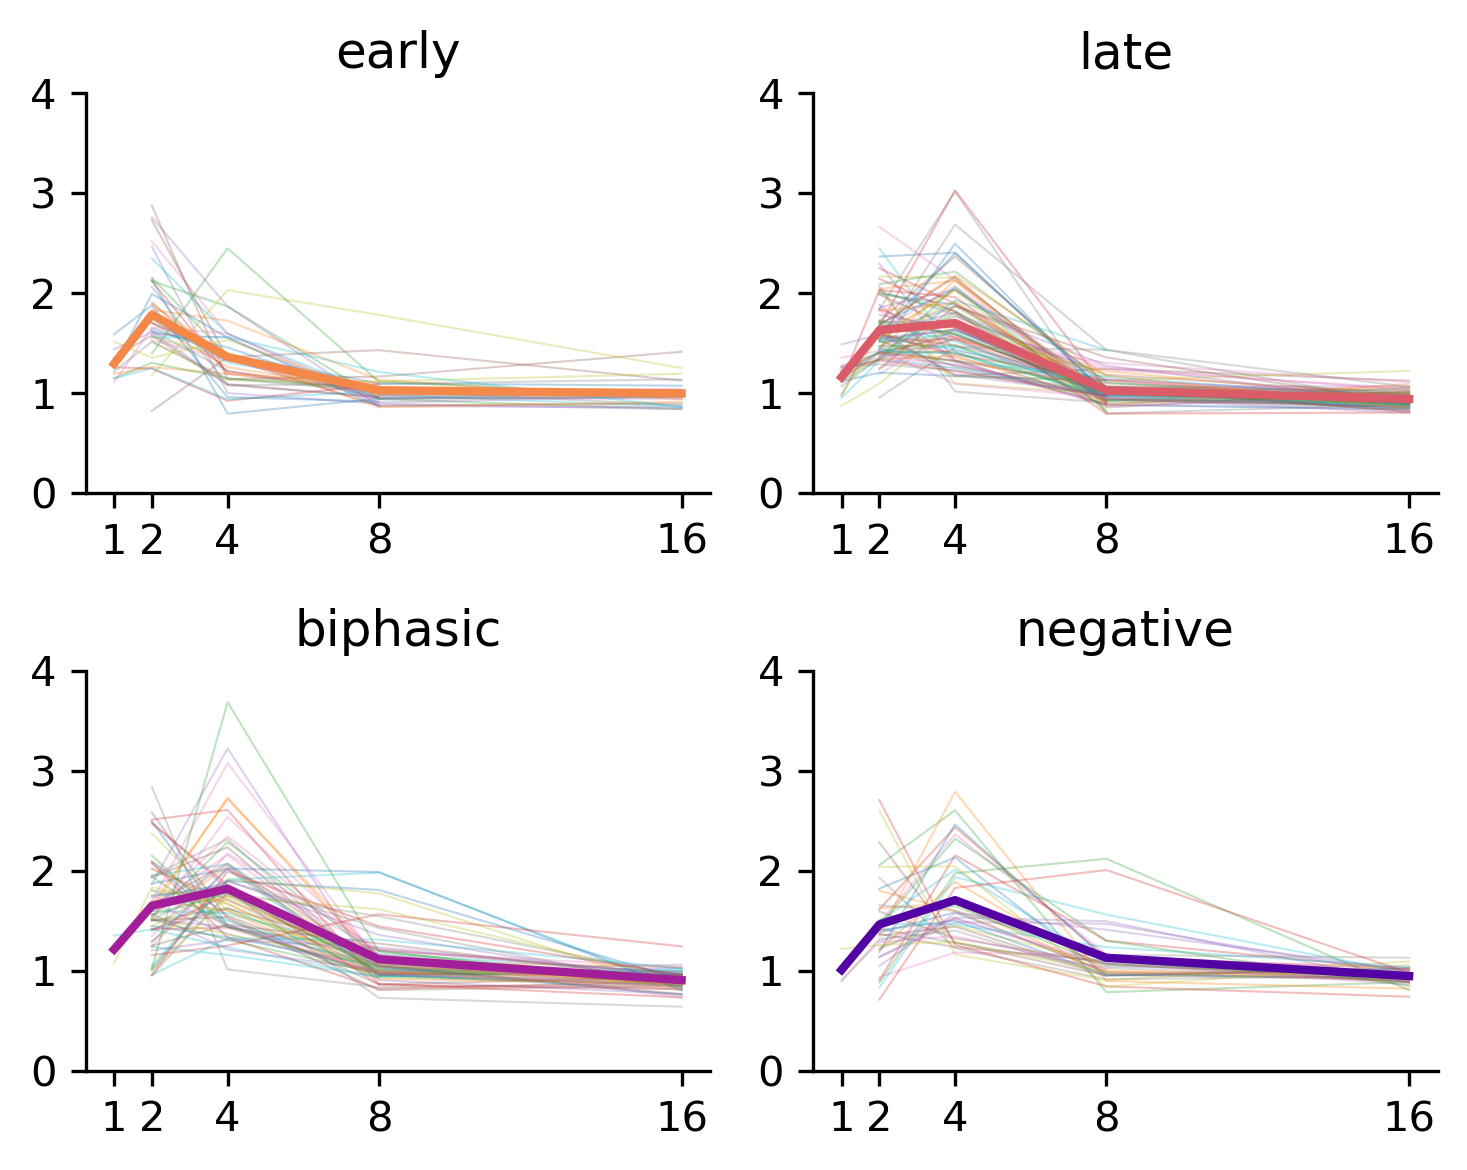

In [285]:
use_counts = np.zeros([4,6])*np.nan

kord = [2,0,3,1]
k_list = ['early','late','biphasic','negative']
k_dict = dict(zip(k_list, kord))

fig, axs = plt.subplots(2,2,figsize=(5,4), dpi=300)
axs = axs.flatten()

for k_i, kname in enumerate(k_list):
    
    use = (grat_resp & (clusters==k_dict[kname]))

    for i in np.where(use)[0]:
        
        axs[k_i].plot(sf_vals, sf_tuning[i,:], alpha=0.3, lw=0.5)

    axs[k_i].plot(sf_vals, np.nanmean(sf_tuning[use,:],0), color=kcolors[kname], lw=2)

    axs[k_i].set_ylim([0,4])

    axs[k_i].set_xticks(sf_vals)

    # axs[k_i].set_xscale('log')
    axs[k_i].set_title(kname)

fig.tight_layout()
fig.savefig('marmo_sf_tuning.png')


In [88]:
sf_vals

array([ 1,  2,  4,  8, 16])

In [93]:
tf_vals

array([ 0.  ,  3.75,  7.5 , 11.25, 15.  , 18.75, 22.5 , 26.25, 30.  ])

In [48]:
np.shape(grat_resp)

(334,)

In [47]:
np.shape(tf_tuning)

(334, 9)

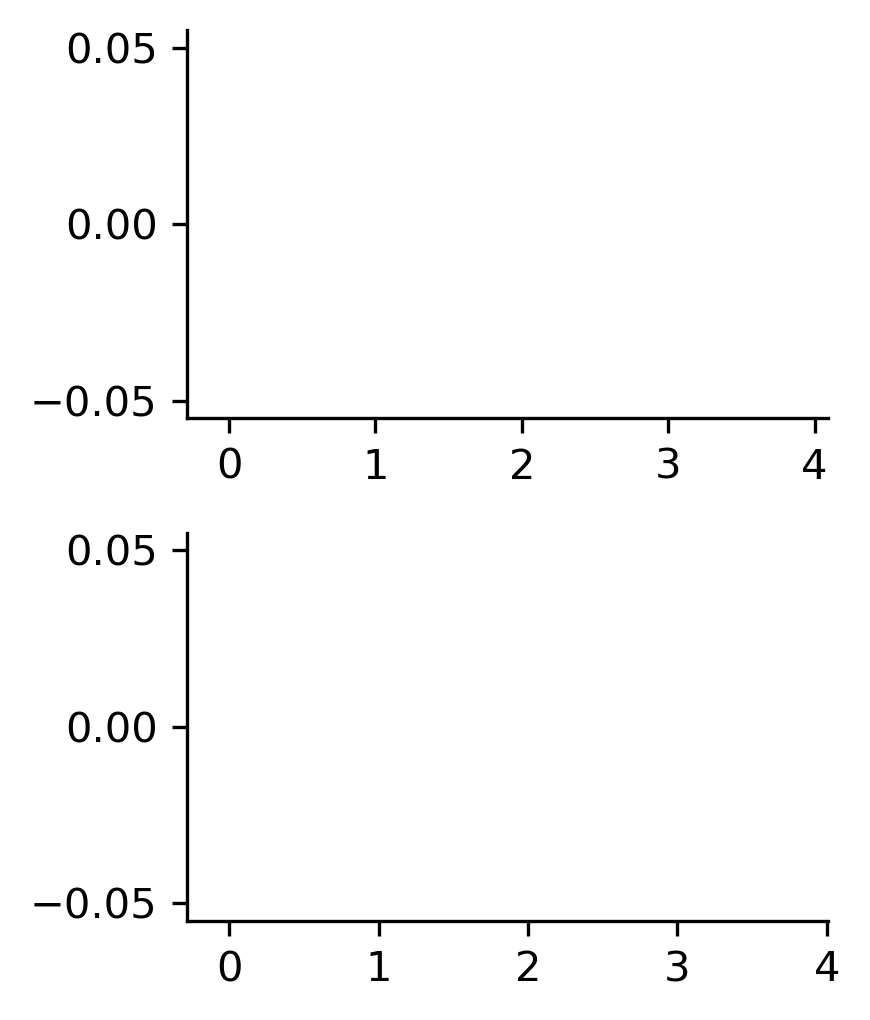

In [56]:
use_counts = np.zeros([4,6])*np.nan

k_list = ['early','late','biphasic','negative']

fig, [ax1,ax2] = plt.subplots(2,1,figsize=(3,3.5), dpi=300)

for k, kname in enumerate([k_list[_k] for _k in kord]):
    
    use = (grat_resp & (clusters==k))
    
    ### TEMPORAL FREQUENCY
    
    tf_bars = np.zeros([np.sum(use), 9])*np.nan
        
    for _i, i in enumerate(np.where(use)[0]):
        for x in range(np.size(tf_bars,1)):
            tf_bars[_i,x] = tf_tuning[i,x] / (np.nansum(tf_tuning[i,:]) - tf_tuning[i,x])

    # count how many rows of tf_bars contain a value greater than 2.0
    num_2to1_pref = np.zeros(np.size(tf_bars,0))
    for x in range(np.size(tf_bars,1)):
        num_2to1_pref[x] = np.nansum(tf_bars[:,x]>2.0) / np.size(tf_bars,0)
    
        ax1.bar(k+((.9/9)*x), num_2to1_pref[x], width=(.9/5), color=kcolors[kname])

    ### SPATIAL FREQUENCY
    
    sf_bars = np.zeros([np.sum(use),5])*np.nan
    
    for _i, i in enumerate(np.where(use)[0]):
        for x in range(np.size(sf_bars,1)):
            sf_bars[_i,x] = sf_tuning[i,x] / (np.nanmax(sf_tuning[i,:]) - sf_tuning[i,x]) # was sum

    num_2to1_pref = np.zeros(np.size(sf_bars,0))
    for x in range(np.size(sf_bars,1)):
        num_2to1_pref[x] = np.nansum(sf_bars[:,x]>2.0) / np.size(sf_bars,0)

        ax2.bar(k+((.9/5)*x), num_2to1_pref[x], width=(.9/5), color=kcolors[kname])
    
# ax.set_xticks([0, 0.38, 1, 1.38, 2, 2.38, 3, 3.38], labels=['l','h','l','h','l','h','l','h'])
# ax.set_ylabel('TF pref. fraction')

# ax1.set_xticks([0,.3,.6,1,1.3,1.6,2,2.3,2.6,3,3.3,3.6], labels=['l','m','h','l','m','h','l','m','h','l','m','h'])
# ax1.set_ylabel('SF pref. fraction')

fig.tight_layout()

# fig.savefig(os.path.join(figpath, 'frac_pref_2to1_TF_SF.pdf'))

In [58]:
np.shape(sf_bars)

(70, 5)

In [57]:
sf_bars[:,x]

array([0.19725712, 0.20839749, 0.23410907, 0.22625802, 0.26286746,
       0.21512887, 0.1757383 , 0.20066807, 0.18936652, 0.22584117,
       0.2101362 , 0.15321583, 0.18719104, 0.21083712, 0.20036632,
       0.17365793, 0.19663425, 0.15490544, 0.20968203, 0.17518811,
       0.1759517 , 0.23082338, 0.25613   , 0.24904062, 0.25494282,
       0.1735454 , 0.23118529, 0.18491996, 0.21577435, 0.30456684,
       0.25055218, 0.21157507, 0.1822939 , 0.12262292, 0.12830401,
       0.22755597, 0.20397772, 0.19709253, 0.19575899, 0.23095776,
       0.16253313, 0.17799398, 0.19007556, 0.15773972, 0.22524497,
       0.16015851, 0.14020113, 0.14930858, 0.17024392, 0.16788384,
       0.1521975 , 0.15956837, 0.21940871, 0.31312202, 0.17863987,
       0.23992587, 0.13935404, 0.22064643, 0.20879454, 0.28492848,
       0.19299405, 0.20798959, 0.15050991, 0.21824266, 0.25567016,
       0.22697738, 0.20477883, 0.17462487,        nan,        nan])

In [42]:
num_2to1_pref

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [40]:
k+((.9/5)*x)

3.7199999999999998

In [39]:
tf_bars

array([[0.17546548, 0.25741583, 0.16532613, ..., 0.06612911, 0.0823433 ,
        0.07735944],
       [0.1817996 , 0.1988709 , 0.22112754, ..., 0.05047193, 0.02502054,
        0.08228448],
       [0.33712076, 0.22742074, 0.19318187, ..., 0.04445801, 0.02415508,
        0.02159459],
       ...,
       [0.33271967, 0.22706568, 0.09578738, ..., 0.09891709, 0.03868476,
        0.08176849],
       [0.20130829, 0.16119414, 0.20377563, ..., 0.06591427, 0.05290828,
        0.04768187],
       [0.34196733, 0.29506995, 0.14539729, ..., 0.05723382, 0.0677546 ,
        0.02854986]])

['biphasic', 'early', 'negative', 'late']

In [33]:
kord

[2, 0, 3, 1]